### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第86天作業
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/06/16
### 改版日期:  
### 改版備註:

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

### ANS:

In [35]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [36]:
train, test = keras.datasets.cifar10.load_data()

In [37]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [38]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [39]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [40]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
MODEL_CHECK=[True,False]

In [41]:
# 載入 Callbacks, 並將監控目標設為 validation loss, 且設定最佳參數時的模型
from keras.callbacks import ModelCheckpoint


results = {}
for mlchk in MODEL_CHECK:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    #存檔路徑
    file_path = "./tmp_MODEL_CHECK_{0}.h5".format(str(mlchk))
    print("Experiment with ModelCheckpoint = %s, filepath = %s" % (mlchk, file_path))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model_ckpt = ModelCheckpoint(filepath=file_path,
                             monitor="val_loss",
                             save_best_only=mlchk)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    model.save("final_model_{0}.h5".format(str(mlchk)))
    model.save_weights("model_weights_{0}.h5".format(str(mlchk)))
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-mlchk-%s" % (str(mlchk))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    if mlchk == True:
        pred_final = model.predict(x_test)
        # Load back
        model = keras.models.load_model(file_path)
        pred_loadback = model.predict(x_test)

Experiment with ModelCheckpoint = True, filepath = ./tmp_MODEL_CHECK_True.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________

50000/50000 [==============================] - 13s 259us/step - loss: 0.5903 - accuracy: 0.8241 - val_loss: 1.5918 - val_accuracy: 0.4977
Epoch 46/50
50000/50000 [==============================] - 13s 256us/step - loss: 0.5732 - accuracy: 0.8324 - val_loss: 1.6386 - val_accuracy: 0.4917
Epoch 47/50
50000/50000 [==============================] - 13s 254us/step - loss: 0.5575 - accuracy: 0.8364 - val_loss: 1.6268 - val_accuracy: 0.4905
Epoch 48/50
50000/50000 [==============================] - 13s 255us/step - loss: 0.5414 - accuracy: 0.8430 - val_loss: 1.6235 - val_accuracy: 0.4929
Epoch 49/50
50000/50000 [==============================] - 13s 258us/step - loss: 0.5239 - accuracy: 0.8496 - val_loss: 1.6692 - val_accuracy: 0.4810
Epoch 50/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.5090 - accuracy: 0.8557 - val_loss: 1.6836 - val_accuracy: 0.4893
Experiment with ModelCheckpoint = False, filepath = ./tmp_MODEL_CHECK_False.h5
Model: "model_1"
________________

50000/50000 [==============================] - 12s 250us/step - loss: 0.6793 - accuracy: 0.7912 - val_loss: 1.5479 - val_accuracy: 0.5031
Epoch 40/50
50000/50000 [==============================] - 13s 252us/step - loss: 0.6596 - accuracy: 0.7979 - val_loss: 1.5529 - val_accuracy: 0.4954
Epoch 41/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.6416 - accuracy: 0.8044 - val_loss: 1.5715 - val_accuracy: 0.5029
Epoch 42/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.6232 - accuracy: 0.8120 - val_loss: 1.5760 - val_accuracy: 0.4917
Epoch 43/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.6068 - accuracy: 0.8182 - val_loss: 1.5878 - val_accuracy: 0.5018
Epoch 44/50
50000/50000 [==============================] - 13s 253us/step - loss: 0.5886 - accuracy: 0.8269 - val_loss: 1.5952 - val_accuracy: 0.4903
Epoch 45/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.5704 - accuracy: 0.8339 - va

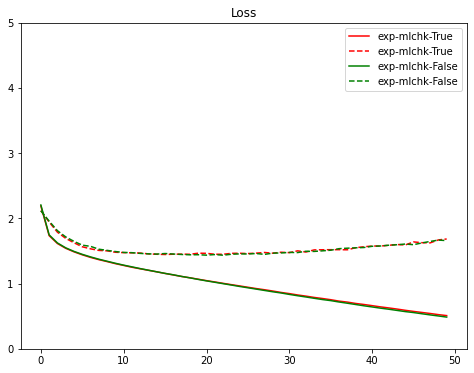

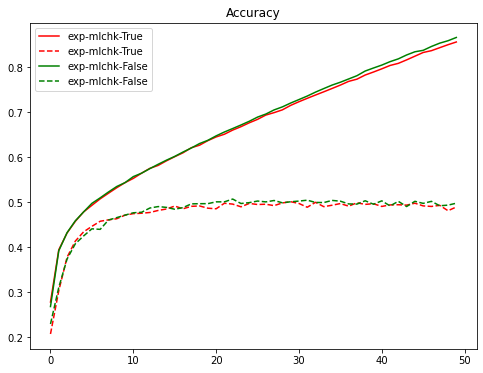

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
# color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

#### 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [43]:
# Load back
import os
import keras
model = keras.models.load_model("./final_model_True.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 353us/step


In [44]:
loss_loadback

1.6835782442092895

In [45]:
acc_loadback

0.489300012588501

In [46]:
from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.489
Accuracy of best weights: 0.491


In [47]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("./model_weights_True.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.092
Accuracy of best weights: 0.489
